In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

%config InlineBackend.figure_formats = ['svg']
os.chdir('/Users/ngdnh/Codespace/parity-qubit/')

# Physical implementation of a $\cos2\varphi$ qubit 

based on high-transmission Josephson junctions...

### Potentials

Standard tunnel junctions have a potential energy $U(\varphi)=-E_J\cos\varphi$, which in principle, does not have any higher harmonic terms such as $\cos2\varphi$ terms. Junctions with a conduction channel of transmission $\tau$ closer to 1 admit the more general Andreev Bound States (ABS) potential,
\begin{align}
U_\tau(\varphi)=-\Delta\sqrt{1-\tau\sin^2\varphi/2},
\end{align}
providing several higher harmonic terms. The potential is still $2\pi$-periodic and can be expanded in Fourier series,
\begin{align}
U_\tau(\varphi)=-\sum A_k\cos k\varphi
\end{align}
If the junction is tunnel, $\tau$ is small, and only the $\cos\varphi$ term in the expansion is important. When $\tau$ becomes larger, the $\cos2\varphi$ term starts to play a more important role, while still staying smaller than the $\cos\varphi$ term.

We now elucidate these concepts. First, we look at the decomposition of the $U_\tau(\varphi)$. We have assumed that
\begin{align}
U_\tau(\varphi)=-\sum A_k\cos k\varphi,\\
\int_{-\pi}^\pi U_\tau(\varphi)\cos k\varphi d\varphi &= -\sum_{n=0}^\infty A_n\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi,\\ &= -A_0\int_{-\pi}^\pi \cos k\varphi d\varphi - \sum_{n>0}^\infty A_n\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi
\end{align}
Note that 
\begin{align}
\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi = \begin{cases}0, k \neq n,\\
2\pi, k = n = 0,\\
\pi, k = n \neq 0
\end{cases}
\end{align}
Alors
\begin{align}
A_0 = -\dfrac{1}{2\pi}\int_{-\pi}^\pi U_\tau(\varphi)d\varphi,\\
A_k = -\dfrac{1}{\pi}\int_{-\pi}^\pi U_\tau(\varphi)\cos k\varphi d\varphi.
\end{align}

In [2]:
def andreev_potential(varphi, tau):
    """ 
    The general Andreev potential.

    """
    return -np.sqrt(1 - tau * np.sin(varphi/2)** 2)

def tunnel(tau, varphi):
    """ 
    Tunneling junction potential, 1st order expansion of Andreev potential.
    """
    return -(tau/4)*np.cos(varphi)-1+tau/4

def cal_A0(tau):
    integral, _ = quad(lambda varphi: andreev_potential(varphi, tau), -np.pi, np.pi)
    A0 = -integral / (2*np.pi)
    return A0

def cal_Ak(k, tau):
    def integrand(varphi):
        return andreev_potential(varphi, tau) * np.cos(k*varphi)
    integral, _ = quad(integrand, -np.pi, np.pi)
    Ak = -integral / np.pi
    return Ak

def reconstructed_potential(varphi, varphi_ext, fourier_decomp):
    """ 
    Compute a potential from Fourier coefficients
    """
    potential = 0
    for k in range(len(fourier_decomp)):
        A_k = fourier_decomp[k]
        potential += - A_k * np.cos(k*(varphi-varphi_ext))
    return potential

We first try a value of $\tau=0.98$. This is quite high. Let $\Delta=1$.

In [3]:
tau_0 = 0.99
Delta_0 = 1

In [4]:
varphi_range = np.linspace(-3*np.pi, 3*np.pi, 100)

fourier_decomp = []

A0 = cal_A0(tau_0)
fourier_decomp.append(A0)
num_coefs = 3
for k in range(1, num_coefs+1):
    Ak = cal_Ak(k, tau_0)
    fourier_decomp.append(Ak)

fourier_decomp

[0.6468015793608901,
 0.4082257769824268,
 -0.07445757815645296,
 0.028495485179153984]

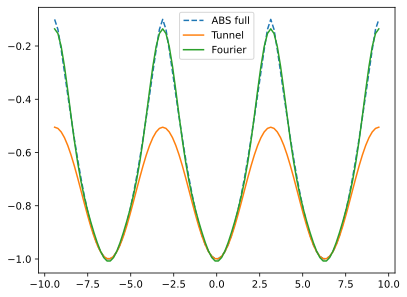

In [5]:
fig, ax = plt.subplots()
ax.plot(varphi_range, [andreev_potential(varphi, tau_0) for varphi in varphi_range], linestyle='--', label='ABS full')
ax.plot(varphi_range, [tunnel(tau_0, varphi) for varphi in varphi_range], label='Tunnel')
ax.plot(varphi_range, [reconstructed_potential(varphi, 0, fourier_decomp) for varphi in varphi_range], label='Fourier')
ax.legend()

Using only 3 terms in the Fourier series, the potential is performing quite good actually. We plot here the $\cos$ at each order.

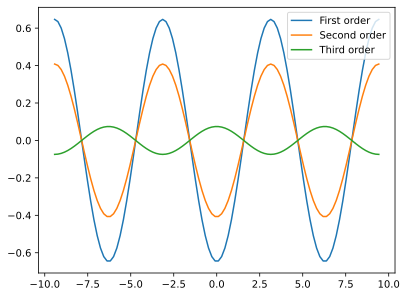

In [6]:
fig, ax = plt.subplots()
ax.plot(varphi_range, - fourier_decomp[0] * np.cos(varphi_range), label='First order')
ax.plot(varphi_range, - fourier_decomp[1] * np.cos(varphi_range), label='Second order')
ax.plot(varphi_range, - fourier_decomp[2] * np.cos(varphi_range), label='Third order')
ax.legend()

### Using interference

To cancel the dominant first harmonics, we consider a circuit made out of two junctions in parallel, forming a superconducting loop threaded by an external magnetic field $\varphi_{\text{ext}}$. Let the phase differences across the two junctions be $\varphi_1$ and $\varphi_2$. The external flux introduces a constraint on the total phase around the loop due to flux quantization,
\begin{align}
\varphi_1-\varphi_2 = 2\pi \dfrac{\varphi_{ext}}{\Phi_0}
\end{align}
where $\Phi_0=h/(2e)$ is the flux quantum. We make one small modification to the previous Andreev Bound State potential: previously, there's only one conduction channel. Here we consider $N_c$ conduction channels. The ABS potential reads,
\begin{align}
U/\Delta&=-\sum_{i=1}^{N_c} \sqrt{1-\tau_{1,i}\sin^2\frac{\varphi_1}{2}} - \sqrt{1-\tau_{2,i}\sin^2\frac{\varphi_2}{2}},\\
&=-\sum_{i=1}^{N_c} \sqrt{1-\tau_{1,i}\sin^2\frac{\varphi_1}{2}} - \sqrt{1-\tau_{2,i}\sin^2\frac{\varphi_1-2\pi\varphi_{ext}/\Phi_0}{2}},\\
&=-\sum_{i=1}^{N_c} \sqrt{1-\tau_{1,i}\sin^2\frac{\varphi_1}{2}} - \sqrt{1-\tau_{2,i}\sin^2\frac{\varphi_1-\Phi'_{ext}}{2}},\\
&\approx-\sum_{k=1}^{k_{max}} \left(A^{(1)}_k\cos k\varphi_1+A^{(2)}_k\cos[k(\varphi_1-\Phi'_{ext})]\right)
\end{align}

In [7]:
taus_data = np.load('./all_taus.npz')
taus_data

NpzFile './all_taus.npz' with keys: Al04, Al22, Al38, MAR01B15, MAR02AC3...

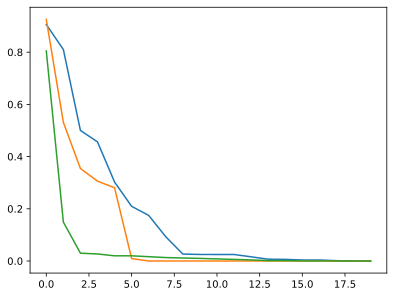

In [8]:
plt.plot(taus_data['Al04'])
plt.plot(taus_data['Al22'])
plt.plot(taus_data['Al38'])

In [9]:
def generalized_ABS(varphi, N_c, phi_ext, taus):
    """ 
    Calculate the generalized Andreev Bound State potential for a junction with several conduction channels
    """
    U = 0
    for i in range(N_c):
        U += np.sqrt(1 - taus[i]*np.sin((phi_ext+varphi)/2)**2)

    return - U

In [10]:
def cal_A0(N_c, phi_ext, taus):
    integral, _ = quad(lambda varphi: generalized_ABS(varphi, N_c, phi_ext, taus), -np.pi, np.pi)
    A0 = -integral / (2*np.pi)
    return A0

def cal_Ak(k, N_c, phi_ext, taus):
    def integrand(varphi):
        return generalized_ABS(varphi, N_c, phi_ext, taus) * np.cos(k*(varphi+phi_ext))
    integral, _ = quad(integrand, -np.pi, np.pi)
    Ak = -integral / np.pi
    return Ak

def Ak_list(N_c, phi_ext, taus, num_coefs):
    fourier_decomp = []
    A0 = cal_A0(N_c, phi_ext, taus)
    fourier_decomp.append(A0)
    for k in range(1, num_coefs+1):
        Ak = cal_Ak(k, N_c, phi_ext, taus)
        fourier_decomp.append(Ak)
    return fourier_decomp

def reconstructed_potential(varphi, varphi_ext, fourier_decomp):
    """ 
    Compute a potential from Fourier coefficients
    """
    potential = 0
    for k in range(len(fourier_decomp)):
        A_k = fourier_decomp[k]
        potential += - A_k * np.cos(k*(varphi+varphi_ext))
    return potential

In [11]:
Ak_list_Al04 = Ak_list(N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04'], num_coefs=2)
Ak_list_Al22 = Ak_list(N_c=len(taus_data['Al22']), phi_ext=-np.pi, taus=taus_data['Al22'], num_coefs=2)
Ak_list_Al38 = Ak_list(N_c=len(taus_data['Al38']), phi_ext=np.pi/2, taus=taus_data['Al38'], num_coefs=2)

Ak_list_Al04, Ak_list_Al22, Ak_list_Al38

([18.940267784721968, 1.1300246233946798, -0.08383091383130167],
 [19.28530446669869, 0.7648685178054623, -0.06095841265133518],
 [19.667238127452137, 0.35512574942854314, -0.02639894153877661])

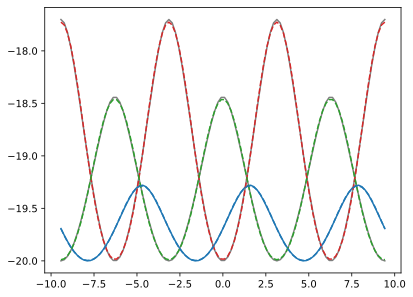

In [12]:
varphi_range = np.linspace(-3*np.pi, 3*np.pi, 100)

fig, ax = plt.subplots()
ax.plot(varphi_range, [generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04']) for varphi in varphi_range], color='tab:gray')
ax.plot(varphi_range, [generalized_ABS(varphi, N_c=len(taus_data['Al22']), phi_ext=np.pi, taus=taus_data['Al22']) for varphi in varphi_range], color='tab:gray')
ax.plot(varphi_range, [generalized_ABS(varphi, N_c=len(taus_data['Al38']), phi_ext=np.pi/2, taus=taus_data['Al38']) for varphi in varphi_range], color='tab:blue')

ax.plot(varphi_range, [reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al04) for varphi in varphi_range], linestyle='--', color='tab:red')
ax.plot(varphi_range, [reconstructed_potential(varphi, np.pi, fourier_decomp=Ak_list_Al22) for varphi in varphi_range], linestyle='--', color='tab:green')
ax.plot(varphi_range, [reconstructed_potential(varphi, np.pi/2, fourier_decomp=Ak_list_Al38) for varphi in varphi_range], linestyle='--', color='tab:blue')

Let us make a circuit out of the two junctions `Al04` and `Al22`. We're interested in the way odd and even terms in their potential interfere.

In [13]:
def visualize_phasors(amplitudes, phases, k):
    """
    Visualize the phasor representation of sinusoidal components.
    """
    amplitudes = np.array(amplitudes)
    phases = np.array(phases)
    phasors = amplitudes * np.exp(1j * k * phases)
    resultant = np.sum(phasors)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plt.gca()

    r = 0 + 0j
    for phasor in phasors:
        next_position = r + phasor
        plt.quiver(r.real, r.imag, 
                   phasor.real, phasor.imag, 
                   angles='xy', scale_units='xy', scale=1, color='tab:blue', alpha=0.7)
        r = next_position

    plt.quiver(0, 0, resultant.real, resultant.imag, angles='xy', scale_units='xy', scale=1, color='tab:green')

    max_amplitude = np.sum(amplitudes)
    ax.set_xlabel('Real')
    ax.set_ylabel('Imag')
    ax.set_xlim(-max_amplitude, max_amplitude)
    ax.set_ylim(-max_amplitude, max_amplitude)
    ax.grid()
    fig.gca().set_aspect('equal', adjustable='box')
    fig.tight_layout()

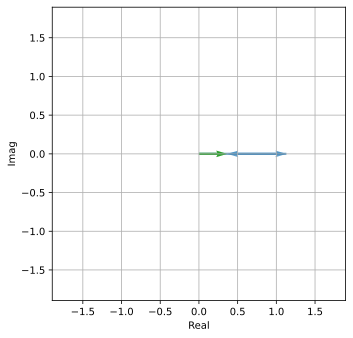

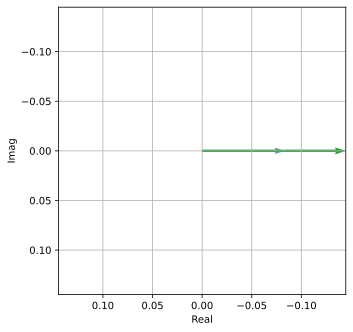

In [ ]:
amplitudes = [Ak_list_Al04[1], Ak_list_Al22[1]]
phases = [0, np.pi]
visualize_phasors(amplitudes, phases, k = 1)
amplitudes = [Ak_list_Al04[2], Ak_list_Al22[2]]
phases = [0, np.pi]
visualize_phasors(amplitudes, phases, k=2)
amplitudes = [Ak_list_Al04[2], Ak_list_Al22[2]]
phases = [0, np.pi]
visualize_phasors(amplitudes, phases, k=2)

We have here the potential of the circuit

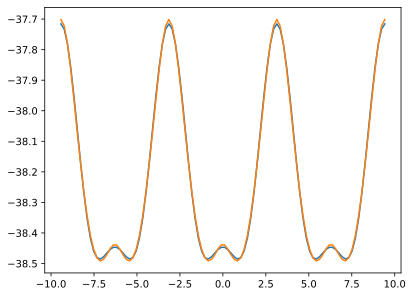

In [16]:
U_2junctions = np.array([reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al04)+reconstructed_potential(varphi, np.pi, fourier_decomp=Ak_list_Al22) for varphi in varphi_range])

plt.plot(varphi_range, U_2junctions)
plt.plot(varphi_range, [generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04'])+generalized_ABS(varphi, N_c=len(taus_data['Al22']), phi_ext=np.pi, taus=taus_data['Al22']) for varphi in varphi_range])

We use QuTiP to construct the corresponding Hamiltonian,

\begin{align}
H &= 4E_C(N-N_g)^2 - U_{\vec{\tau},\Phi_{ext}}(\varphi_1, \varphi_2),\\
&=4E_C(N-N_g)^2 - \sum_{k=1}^{k_{max}} [A_k^{(1)}\cos k\varphi_1+A_k^{(2)}\cos k\varphi_2],\\
&=4E_C(N-N_g)^2 - \sum_{k=1}^{k_{max}} [A_k^{(1)}\cos k\varphi_1+A_k^{(2)}\cos k(\varphi_1-\Phi_{ext})],\\
&=4E_C\sum_{N=-\infty}^\infty(N-N_g)^2|N\rangle\langle N| + \frac{E_J}{2} \sum_{N=-\infty}^{\infty} |N\rangle\langle N+2| + |N+2\rangle\langle N|,
\end{align}

We now envision a circuit made of four junctions in parallel, making three superconducting loops. We let the magnetic flux threading through these three superconducing loops. The potential energy can be written as 
\begin{align}
U(\varphi)&=-\sum_{i=1}^4\sum_{k>0} A_{k}^{(i)}\cos[k(\varphi-\varphi_i)],
\end{align}
where $\varphi_1=0, \varphi_2=2\pi\Phi_A/\Phi_0, \varphi_3=2\pi(\Phi_A+\Phi_B)/\Phi_0, \varphi_4=2\pi(\Phi_A+\Phi_B+\Phi_C)/\Phi_0$. 